## Mnist Clan-ssifier ;)

Here we demonstrate how to use the EZKL package to build an MNIST classifier for on-chain handrawn digit recognition.
The proofs get submitted to a contract that assigns the users account to a digit clan (0-9). The contract keeps track of the member count of each clan. The clan with the most members is the winner!

![zk-gaming-diagram-transformed](https://file.notion.so/f/f/f9535faf-4480-4499-9059-a48ba240eaa9/cd13414a-ecd8-4b8f-90a1-8a2311baa278/Untitled.png?id=365d66ee-e653-4ec3-8eb6-6d2b6306455a&table=block&spaceId=f9535faf-4480-4499-9059-a48ba240eaa9&expirationTimestamp=1701568800000&signature=VJ9p3YsOjYjeLxmkVEWOJw_3VmM6IBkTYxMwQUFKeus&downloadName=Untitled.png)
> **A typical ZK application flow**. For all the image classifictiton hackers out there — this is an fairly straight forward example. A user computes a ZKML-proof that they have calculated a valid classification of a hand drawn digit from a MNIST trained lenet model. They submit this proof to a verifier contract which governs a set of clans, along with the output values of the model (length 10 tensor whereby the index with the max value represented the prediction), and the clan count updates according the lenets model's prediction. 

In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging


# uncomment for more descriptive logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In [2]:
import torch

In [3]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [4]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import Adam  # Import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import pandas as pd

def normalize_img(image, label):
  return torch.round(image), label

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print("device is {}".format(device))

# from data.local_torch_datasets import train_dataset, test_dataset, number_of_categories
# # train_dataset_df = pd.read_csv("data/train_dataset.csv")
# # test_dataset_df = pd.read_csv("data/test_dataset.csv")

# print(type(train_dataset))
# print(len(train_dataset))

# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
# test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)

# print(type(train_dataset))
# print(train_dataset[0])

device is cpu


/tmp/ipykernel_15030/2084954907.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
import glob
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

# https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d

class TrainDataset(Dataset):
    def __init__(self,path):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append((img_path, int(class_name)))
        print(self.data)
        self.img_dim = (100, 20)

    def __len__(self):
        return len(self.data)
     
    def __getitem__(self, idx):
        img_path, class_id = self.data[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # img = cv2.imread(img_path)
        # print("IMG HAS SIZE {}".format(img.shape))
        img = cv2.resize(img, self.img_dim)
        img = img.astype("float32")
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.to(device)
        # img_tensor = torchvision.transforms.ToTensor(img_tensor)
        img_tensor = img_tensor.reshape((img_tensor.shape[0],img_tensor.shape[1],1))
        img_tensor = img_tensor.permute(2, 0, 1)
        # print("IMG HAS SIZE {}".format(img.shape))
        # print("IMG TENSOR HAS SIZE {}".format(img_tensor.shape))
        # class_id = torch.tensor(class_id)
        class_id = int(class_id)
        # img_tensor = img_tensor.permute(2, 0, 1)
        return (img_tensor, class_id)
    

train_dataset = TrainDataset("/home/benjamin/circuit_breaker/ezkl/data/train_dataset/")
test_dataset = TrainDataset("/home/benjamin/circuit_breaker/ezkl/data/test_dataset/")
number_of_categories = 3

print("GET ITEM 0: ", train_dataset.__getitem__(0)[0])


# train_loader = DataLoader(train_dataset, batch_size=1)
# test_loader = DataLoader(test_dataset, batch_size=1)


# print(len(train_loader))

[('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/790.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/956.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/585.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/228.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/461.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/330.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/106.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/934.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/948.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/847.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/755.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/904.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_dataset/0/113.png', 0), ('/home/benjamin/circuit_breaker/ezkl/data/train_d

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

        # Fully connected layers / Dense block
        # self.fc1 = nn.Linear(16 * 4 * 4, 120) 
        # self.fc1 = nn.Linear(463344, 120) 
        self.fc1 = nn.Linear(704, 120) 
        self.fc2 = nn.Linear(120, 84)         # 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, number_of_categories)          # 84 inputs, 10 outputs (number of classes)

    def forward(self, x):
        # Convolutional block
        x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)  # No activation function here, will use CrossEntropyLoss later
        return x


In [7]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [8]:

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

from PIL import Image
from matplotlib import pyplot as plt


# print(len(train_dataset))
# print(len(train_loader))
# print(len(test_dataset))
# print(len(test_loader))
model = LeNet().to(device)
adam = Adam(model.parameters())  # Using Adam with a learning rate of 1e-3
loss_fn = CrossEntropyLoss()
all_epoch = 25
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        # train_x = train_x.round()
        # print("train_label is {}".format(train_label))
        # plt.imshow(train_x[0][0], interpolation='nearest')
        # plt.show()
        # print("train_x is {}".format(train_x[0][0]))
        train_label = train_label.to(device)
        adam.zero_grad()  # Use adam optimizer
        predict_y = model(train_x.float())
        # print("train_predict is {}".format(predict_y))
        # print("train label long {}".format(train_label.long()))
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        adam.step()  # Use adam optimizer
    all_correct_num = 0
    all_sample_num = 0
    model.eval()

    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        # im = Image.fromarray(test_x[0].numpy())
        # im.show()
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        # print("test_x is {}".format(test_x.numpy()))
        # print("test_x max is {}".format(test_x.max()))
        # print("test_label is {}".format(test_label))
        # print(predict_y)
        predict_y = torch.argmax(predict_y, dim=-1)
        # print(predict_y)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('test accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/income_simple_{:.3f}.pkl'.format(acc))
    prev_acc = acc


test accuracy: 0.400
test accuracy: 0.500
test accuracy: 0.600
test accuracy: 0.600
test accuracy: 0.600
test accuracy: 0.600
test accuracy: 0.600
test accuracy: 0.600
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000
test accuracy: 1.000


tensor(1.2501e-07, grad_fn=<MinBackward1>)


Text(0.5, 1.0, 'Absolute value of parameters')

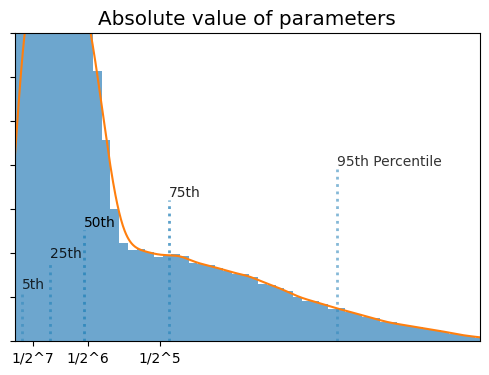

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import stats
n_bins = 100
# whats the smallest parameter in this model ?
minimum_abs_val = 100000
params_abs = []
for param in model.parameters():
  if param.abs().min() < minimum_abs_val:
    minimum_abs_val = param.abs().min()
  params_abs.extend(param.abs().detach().numpy().flatten().tolist())

print(minimum_abs_val)

xx = np.linspace(0, 0.2, 1000)

kde = stats.gaussian_kde(params_abs)
fig, ax = plt.subplots(figsize = (6,4))

ax.set_xlim(0, 0.2)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = ax.hist(params_abs, bins=n_bins, density = True, alpha =0.65)
ax.plot(xx, kde(xx))


ax.set_ylim(0, 14)
ax.set_yticklabels([])
ax.set_ylabel("")
plt.style.use("bmh")
ax.set_xticks([1.0/128.0, 1.0/32.0, 1.0/16.0])
ax.set_xticklabels(["1/2^7", "1/2^6", "1/2^5"])
ax.grid(False)
# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = np.quantile(params_abs, 0.05), np.quantile(params_abs, 0.25), np.quantile(params_abs, 0.5), np.quantile(params_abs, 0.75), np.quantile(params_abs, 0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# Annotations
ax.text(quant_5, 14 * 0.17, "5th", size = 10, alpha = 0.8)
ax.text(quant_25, 14 * 0.27, "25th", size = 10, alpha = 0.85)
ax.text(quant_50, 14 * 0.37, "50th", size = 10, alpha = 1)
ax.text(quant_75, 14 * 0.47, "75th", size = 10, alpha = 0.85)
ax.text(quant_95, 14 * 0.57, "95th Percentile", size = 10, alpha =.8)

ax.set_title("Absolute value of parameters")

In [10]:
import os

model_path = os.path.join('network_lenet.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('key.pk')
vk_path = os.path.join('key.vk')
settings_path = os.path.join('settings.json')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [11]:
import torch
import json

model.eval()  # Set the model to evaluation mode

# # Fetch a single data point from the train_dataset
# # Ensure train_dataset is already loaded and accessible
train_data_point, _ = next(iter(train_dataset))
train_data_point = train_data_point.unsqueeze(0)  # Add a batch dimension

# Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_point = train_data_point.to(device)

# # Export the model to ONNX format
torch.onnx.export(model, train_data_point, model_path, export_params=True, opset_version=12, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

# Convert the tensor to numpy array and reshape it for JSON serialization
x = train_data_point.cpu().detach().numpy().reshape([-1]).tolist()
data = {'input_data': [x]}
with open('input.json', 'w') as f:
    json.dump(data, f)

print(f"Model exported to {model_path} and input data saved to input.json")

Model exported to network_lenet.onnx and input data saved to input.json


In [12]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 1)]

# Capture set of data points
num_data_points = 8

# Fetch 30 data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)

# Stack the data points to create a batch
train_data_batch = torch.stack(data_points)

# Add a batch dimension if not already present
if train_data_batch.dim() == 3:
    train_data_batch = train_data_batch.unsqueeze(0)

x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

data = dict(input_data = [x])

cal_path = os.path.join('cal_data.json')

# Serialize data into file:
json.dump( data, open(cal_path, 'w' ))

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[2,7])
assert res == True

INFO ezkl.graph.model 2024-02-17 16:34:43,123 model.rs:614 set batch_size to 1
INFO ezkl.graph.model 2024-02-17 16:34:43,170 model.rs:496 model has 1 instances
INFO ezkl.graph.model 2024-02-17 16:34:43,172 model.rs:1344 calculating num of constraints using dummy model layout...
INFO ezkl.graph.model 2024-02-17 16:34:43,453 model.rs:1404 model uses 428854 rows (coord=857708, constants=798043)
INFO ezkl.graph.model 2024-02-17 16:34:43,464 model.rs:614 set batch_size to 1
INFO ezkl.execute 2024-02-17 16:34:43,487 execute.rs:816 num of calibration batches: 8
INFO ezkl.execute 2024-02-17 16:34:43,488 execute.rs:818 running onnx predictions...
INFO ezkl.graph.model 2024-02-17 16:34:43,489 model.rs:614 set batch_size to 1
INFO tract_linalg.x86_64_fma 2024-02-17 16:34:43,492 x86_64_fma.rs:14 qmmm_i32: x86_64/avx2 activated
INFO tract_linalg.x86_64_fma 2024-02-17 16:34:43,493 x86_64_fma.rs:93 mmm_f32, mmv_f32, sigmoid_f32, tanh_f32: x86_64/fma activated
INFO ezkl.graph.model 2024-02-17 16:34:43

In [13]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

INFO ezkl.graph.model 2024-02-17 16:35:30,828 model.rs:614 set batch_size to 1


In [14]:
# srs path
res = ezkl.get_srs(settings_path)

INFO ezkl.execute 2024-02-17 16:35:30,881 execute.rs:541 SRS does not exist, downloading...
INFO ezkl.execute 2024-02-17 16:35:34,827 execute.rs:557 SRS downloaded
INFO ezkl.execute 2024-02-17 16:35:35,123 execute.rs:493 SRS hash: d1a1655b4366a766d1578beb257849a92bf91cb1358c1a2c37ab180c5d3a204d


In [15]:
# now generate the witness file
witness_path = "witness.json"

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

INFO ezkl.graph 2024-02-17 16:35:35,140 mod.rs:831 input scales: [2]
INFO ezkl.graph.model 2024-02-17 16:35:35,142 model.rs:1344 calculating num of constraints using dummy model layout...
INFO ezkl.graph.model 2024-02-17 16:35:35,375 model.rs:1404 model uses 180705 rows (coord=361410, constants=323149)


In [16]:
res = ezkl.mock(witness_path, compiled_model_path)
assert res == True

INFO ezkl.execute 2024-02-17 16:35:35,442 execute.rs:1158 Mock proof
INFO ezkl.graph.vars 2024-02-17 16:35:35,443 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:35:35,444 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:35:35,445 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 7,
  "num_instances": 1,
  "num_selectors": 30
}
WARNING ezkl.circuit.modules.planner 2024-02-17 16:35:35,595 planner.rs:122 spawning module 2
INFO ezkl.graph.model 2024-02-17 16:35:35,596 model.rs:1043 model layout...
INFO ezkl.graph.model 2024-02-17 16:35:39,442 model.rs:1135 model uses 173763 rows (coord=347526, constants=297674)


In [17]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

INFO ezkl.pfsys.srs 2024-02-17 16:35:41,210 srs.rs:23 loading srs from "/home/benjamin/.ezkl/srs/kzg19.srs"
INFO ezkl.execute 2024-02-17 16:35:41,294 execute.rs:2097 downsizing params to 19 logrows
INFO ezkl.graph.vars 2024-02-17 16:35:41,295 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:35:41,295 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:35:41,296 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 7,
  "num_instances": 1,
  "num_selectors": 30
}
WARNING ezkl.circuit.modules.planner 2024-02-17 16:35:41,430 planner.rs:122 spawning module 2
INFO ezkl.graph.model 2024-02-17 16:35:41,430 model.rs:1043 model layout...
INFO ezkl.graph.model 2024-02-17 16:35:44,669 model.rs:1135 model uses 173763 rows (coord=347526, constants=297674)
INFO ezkl.pfsys 2024-02-17 16:36:04,039 mod.rs:450 VK took 22.744
INFO ezkl.graph.vars 2024-02-17 16:36:04,039 vars.rs:413 number of blinding factors: 5
INFO ezkl.grap

In [18]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

INFO ezkl.pfsys.srs 2024-02-17 16:36:45,836 srs.rs:23 loading srs from "/home/benjamin/.ezkl/srs/kzg19.srs"
INFO ezkl.execute 2024-02-17 16:36:45,932 execute.rs:2097 downsizing params to 19 logrows
INFO ezkl.pfsys 2024-02-17 16:36:45,933 mod.rs:700 loading proving key from "key.pk"
INFO ezkl.graph.vars 2024-02-17 16:36:45,934 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:36:45,934 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:36:45,935 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 7,
  "num_instances": 1,
  "num_selectors": 30
}
INFO ezkl.pfsys 2024-02-17 16:36:52,819 mod.rs:524 proof started...
INFO ezkl.graph.vars 2024-02-17 16:36:52,820 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:36:52,820 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:36:52,821 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 

{'instances': [['1d21000000000000000000000000000000000000000000000000000000000000', 'e013000000000000000000000000000000000000000000000000000000000000', '65cfffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430']], 'proof': '0x1049a0f8890c9fe1db3139691280e4b6b73842774767336230ca6599b79ca2ec2bc81192161149faac41c24b1840f8c956ee4f0e18a255001987d9f483a1176d0aa5fa210ca27d2f4ba62b230b23b808a6722bdaadb11aa1cc7eccb055b7d3c100f21b170317c78d80af9ba1ac0d5c2ff93b83cc0dc16b7a331c1155452f552c147f23ef1c0ea268f802b056ae12b61f5c6fa84b843be810b2f2d6b899da627a1861a6ad125e50f637f301cd7ae97d3aa04fc0768efb66ca6ed71e07fe80127824eca750c2b0f56efa39c4150b7378edfd231c62a4dfe4dd2e1a8278dc59aa29183df08e541eb2aee1f984c91d8d6741fe6717e473c67e8268121d71044795c4178ef431157532608988732bdf597af8465490aa70a001b0ced4b0be2f01c305006641f8130f0344336341b557865a9d25fc2b804548cf1a2e3333003110ce110cd83de0a656d253510f3f3e5e6d2261fa825ffa5b5d7ea4444b9143f593e192000b09bf0039f0de0d82ef42611e90c632cfadbded8bccf88ba3bf46083389

In [19]:
# VERIFY IT
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

INFO ezkl.pfsys.srs 2024-02-17 16:38:16,797 srs.rs:23 loading srs from "/home/benjamin/.ezkl/srs/kzg19.srs"
INFO ezkl.execute 2024-02-17 16:38:16,884 execute.rs:2097 downsizing params to 19 logrows
INFO ezkl.pfsys 2024-02-17 16:38:16,885 mod.rs:678 loading verification key from "key.vk"
INFO ezkl.graph.vars 2024-02-17 16:38:16,886 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:38:16,886 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:38:16,887 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 7,
  "num_instances": 1,
  "num_selectors": 30
}
INFO ezkl.execute 2024-02-17 16:38:16,893 execute.rs:2055 verify took 0.4
INFO ezkl.execute 2024-02-17 16:38:16,893 execute.rs:2060 verified: true


verified


We can now create an EVM / `.sol` verifier that can be deployed on chain to verify submitted proofs using a view function.

In [20]:

abi_path = 'test.abi'
sol_code_path = 'test_1.sol'

res = ezkl.create_evm_verifier(
        vk_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

INFO ezkl.execute 2024-02-17 16:38:16,905 execute.rs:75 checking solc installation..
INFO ezkl.pfsys.srs 2024-02-17 16:38:16,921 srs.rs:23 loading srs from "/home/benjamin/.ezkl/srs/kzg19.srs"


INFO ezkl.execute 2024-02-17 16:38:17,028 execute.rs:2097 downsizing params to 19 logrows
INFO ezkl.pfsys 2024-02-17 16:38:17,029 mod.rs:678 loading verification key from "key.vk"
INFO ezkl.graph.vars 2024-02-17 16:38:17,029 vars.rs:413 number of blinding factors: 5
INFO ezkl.graph.model 2024-02-17 16:38:17,030 model.rs:1005 configuring model
INFO ezkl.graph 2024-02-17 16:38:17,031 mod.rs:1476 circuit size: 
 {
  "num_advice_columns": 6,
  "num_challenges": 0,
  "num_fixed": 7,
  "num_instances": 1,
  "num_selectors": 30
}


## Verify on the evm

In [21]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

INFO ezkl.execute 2024-02-17 16:38:17,285 execute.rs:75 checking solc installation..


RuntimeError: Failed to run deploy_evm: error sending request for url (http://127.0.0.1:3030/): error trying to connect: tcp connect error: Connection refused (os error 111)

In [ ]:
# make sure anvil is running locally
# $ anvil -p 3030

res = ezkl.verify_evm(
    addr,
    proof_path,
    "http://127.0.0.1:3030"
)
assert res == True